1. word vectorize
2. word count
3. LDA (topic search)


In [1]:
import base64
import numpy as np
import pandas as pd

!pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

from collections import Counter
from imageio import imread
#from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
train = pd.read_csv("../_Kaggle/input/train 3.csv")

# 1. EDA

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print(train.shape)

(19579, 3)


## Summary statistics of the training

In [5]:
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [6]:
z = {'EAP' :'Edgar Allen Poe','MWS':'Mary Shelley','HPL':'HP Lovecraft'}
# box plot 그리기
data =[go.Bar(
    x = train.author.map(z).unique(),
    y = train.author.value_counts().values,
    marker = dict(colorscale ='Jet',
                 color = train.author.value_counts().values),
    #text ='Text entries attributed to Author'
)]
fig=go.Figure(data = data)
py.iplot(fig, filename='basic-bar')

In [7]:
words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
    x = words.index.values[0:50],
    y = words.values[0:50],
    marker = dict(colorscale='jet',
                 color = words.values[2:100]),
    text ='Word counts'
)]

fig=go.Figure(data = data)
py.iplot(fig, filename ='basic-bar')

## WordsClouds to visualise

In [8]:
eap = train[train.author=='EAP']['text'].values
hpl = train[train.author=='HPL']['text'].values
mws = train[train.author=='MWS']['text'].values

In [9]:
print(eap.shape)

(7900,)


In [10]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

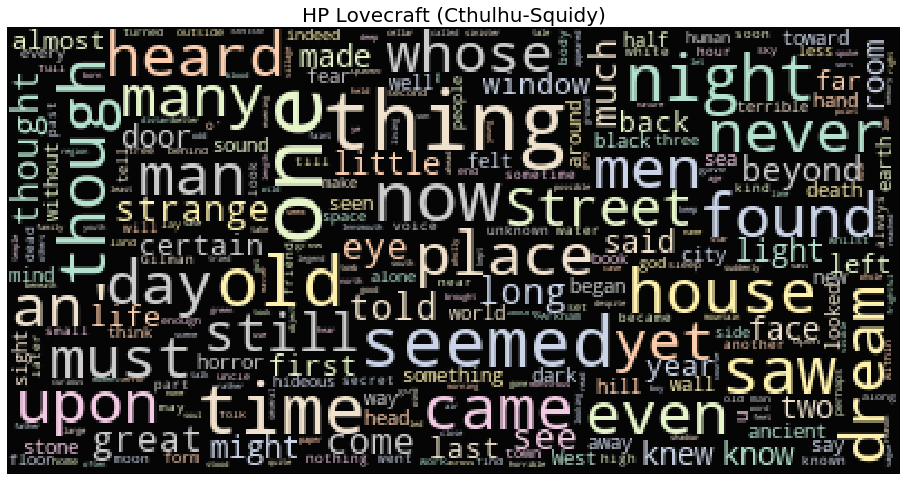

In [11]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

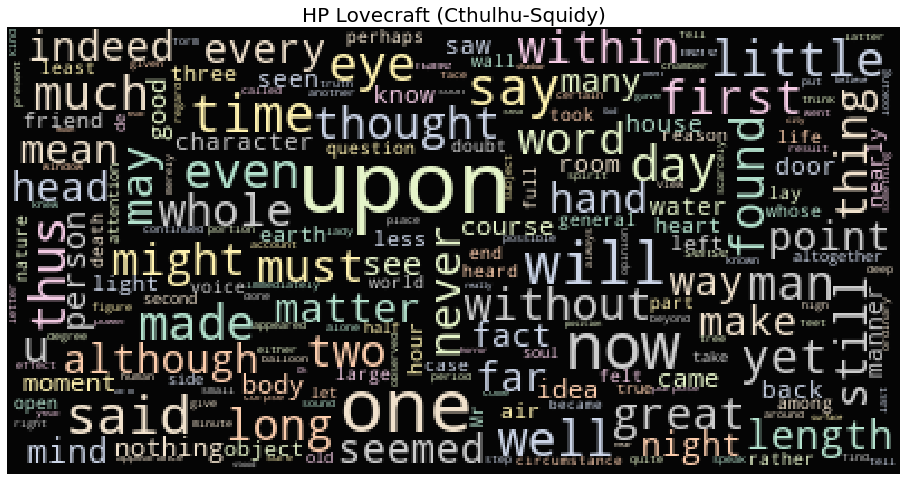

In [12]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

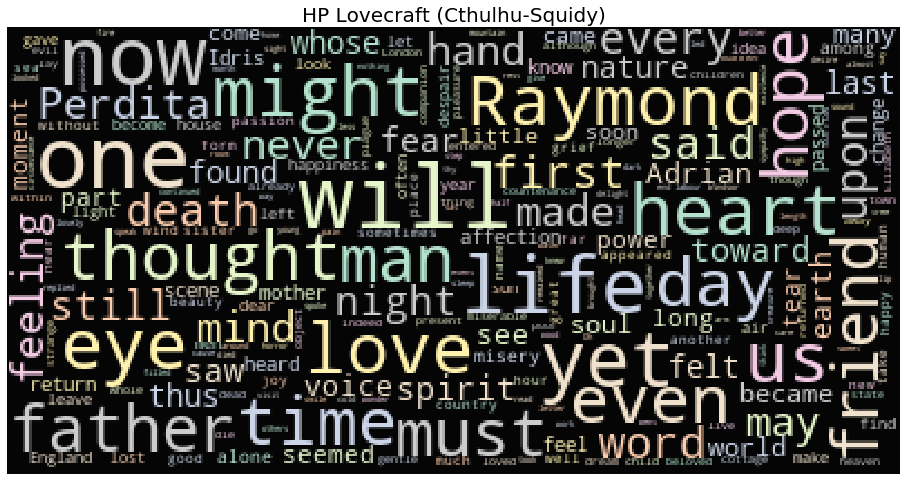

In [13]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

# Tokenization

## Natural Langugage Toolkit(NLTK):
To make our Natural Langugage Processing endeavors more convenient

In [14]:
# 1. using split""
first_text = train.text.values[0]
first_text.split(" ")


['This',
 'process,',
 'however,',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon;',
 'as',
 'I',
 'might',
 'make',
 'its',
 'circuit,',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'I',
 'set',
 'out,',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact;',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall.']

In [15]:
# 2. using word_tokenize

import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [16]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


# Stopword Removal

Remove the words that don't contribute to the learning or predictive process as a learning model such as 'to' or 'the'
NLTK already defined the 153 english stopwords

In [17]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [18]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
first_text_list_cleaned =[word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']


In [27]:
print('Length of original list: {0} words\n'
     'Length of list after stopwords removal:{1} words' .format(len(first_text_list), len(first_text_list_cleaned)))

Length of original list: 48 words
Length of list after stopwords removal:28 words


In [28]:
print('Length of original list: {0} words\n'
     'Length of list after stopwords removal:{1} words',len(first_text_list), len(first_text_list_cleaned))

Length of original list: {0} words
Length of list after stopwords removal:{1} words 48 28


# 2. Stemming and Lemmatization

- running, runs and run from the same a word 'run'
- using Porter stemming algorithm, the lancaster stemmer and snowball stemmer

In [29]:
stemmer = nltk.stem.PorterStemmer()

In [30]:
print("The stemmed form of running is : {}".format(stemmer.stem("running")))
print("The stemmed form of runs is : {}".format(stemmer.stem("runs")))
print("The stemmed form of run is :{}".format(stemmer.stem("run")))

The stemmed form of running is : run
The stemmed form of runs is : run
The stemmed form of run is :run


In [31]:
# Lemmatization to the rescue

from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print('The lemmatized form of leaves is : {}'.format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is : leaf


# 3. Vectorizing Raw text

- Convert our text into numbers for which we utilise a very common approach known as the Bag-of Words

- The Bag of words approach: vectorizer that generates a vector of word counts

In [35]:
sentence =["I love to eat Burgers",
          "I love to eat Fries"]

vectorizer = CountVectorizer(min_df =0)# min_df = minimum of value set
sentence_transform = vectorizer.fit_transform(sentence)
print(sentence_transform)

  (0, 3)	1
  (0, 4)	1
  (0, 1)	1
  (0, 0)	1
  (1, 3)	1
  (1, 4)	1
  (1, 1)	1
  (1, 2)	1


In [36]:
vectorizer.get_feature_names()

/Users/YangsuYun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['burgers', 'eat', 'fries', 'love', 'to']

In [37]:
sentence_transform.toarray()

array([[1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1]])

In [38]:
sentence_transform

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

# Topic modelling

1. Latent Dirichlet Allocation(LDA) :
2. Non-negative Matrix Factorization(NMF)

In [39]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message ="\nTopic#{}:".format(index)
        message+= " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:
                                                                     -1]])
        print(message)
        print("="*70)

# Putting all the preprocessing steps together

When you vectorize the raw text with Count vectorizer, the dual stages of tokenizing and stopwords filtering are automatically included as high-level component excep the lemmatizer

In [40]:
# Extending the Count vectorizer class with a lemmatizer
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [41]:
# Storing the entire training text in a list
text = list(train.text.values)
#calling our overwritten Count vectorizer
#max_df 은 너무 많이 나오는 단어는 무시해 (95%이상 나온 단어는 무시해)
#min_df 은 너무 적게 나온 단어를 무시해
tf_vectorizer = LemmaCountVectorizer(max_df = 0.95,
                                    min_df=2,
                                    stop_words='english',
                                    decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [42]:
# Revisiting our Term frequencies

feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x,y = (list(x) for x in zip(*sorted(zipped, key = lambda x:x[1], reverse=True)))


In [46]:
Y = np.concatenate([y[0:15],y[-16:-1]])
X = np.concatenate([x[0:15],x[-16:-1]])


array([ 2, 11, 29, ...,  3,  2,  2], dtype=int64)

In [49]:
data = [go.Bar(
x=x[0:50],
y=y[0:50],
marker = dict(colorscale='Jet', color=y[0:50]),
text='Word counts')]

fig= go.Figure(data= data)
py.iplot(fig, filename ='basic-bar')


# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# 3. Latent Dirichlet Allocation
Sklearn's implementation
LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.

예)
문서1 : 저는 사과랑 바나나를 먹어요
문서2 : 우리는 귀여운 강아지가 좋아요
문서3 : 저의 깜찍하고 귀여운 강아지가 바나나를 먹어요

<각 문서의 토픽 분포>
문서1 : 토픽 A 100%
문서2 : 토픽 B 100%
문서3 : 토픽 B 60%, 토픽 A 40%

<각 토픽의 단어 분포>
토픽A : 사과 20%, 바나나 40%, 먹어요 40%, 귀여운 0%, 강아지 0%, 깜찍하고 0%, 좋아요 0%
토픽B : 사과 0%, 바나나 0%, 먹어요 0%, 귀여운 33%, 강아지 33%, 깜찍하고 16%, 좋아요 16%

1. n_components: The number of topics that you specify to the model
2. a parameter: This is the dirichlet parameter that can be linked to the document topci prior
3. B parameter: This is the dirichlet parameter linked to the topic word prior

The optimal vlaue of n_components was found by couducting a KMeans + Latent Semantic Analysis scheme whereby the number of Kmeans clusters and number of LSA dimensions were iterated through and the best silhouette mean score

In [61]:
lda = LatentDirichletAllocation(n_components = 4, max_iter = 5, 
                               learning_method='online',
                               learning_offset=50.,
                               random_state =0)
#주제가 11개

In [62]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=4, random_state=0)

In [63]:
#print_top_words 구조 살펴보기
print_top_words

<function __main__.print_top_words(model, feature_names, n_top_words)>

In [64]:
n_top_words = 10
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic#0:dream old did soon mean year think fact like say

Topic#1:life death mind heart love man night nature time shall

Topic#2:thing thought said hand word man day eye come voice

Topic#3:house door light room hour saw like strange city night


/Users/YangsuYun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [67]:
lda.components_[0].shape

(13781,)

In [68]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [70]:
# word cloud visualization of the topics
first_topic_words =[tf_feature_names[i] for i in first_topic.argsort()[:-50 -1 :-1]]
second_topic_words =[tf_feature_names[i] for i in second_topic.argsort()[:-50 -1 :-1]]
third_topic_words =[tf_feature_names[i] for i in third_topic.argsort()[:-50 -1 :-1]]
fourth_topic_words =[tf_feature_names[i] for i in fourth_topic.argsort()[:-50 -1 :-1]]

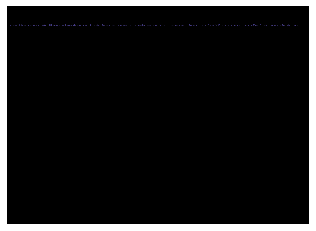

In [72]:
firstcloud = WordCloud(
stopwords = STOPWORDS,
background_color ='black',
width = 2500,
    height =1800
).generate("".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

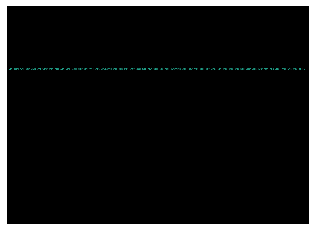

In [73]:
firstcloud = WordCloud(
stopwords = STOPWORDS,
background_color ='black',
width = 2500,
    height =1800
).generate("".join(second_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

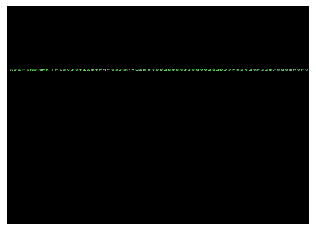

In [74]:
firstcloud = WordCloud(
stopwords = STOPWORDS,
background_color ='black',
width = 2500,
    height =1800
).generate("".join(third_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

In [ ]:
firstcloud = WordCloud(
stopwords = STOPWORDS,
background_color ='black',
width = 2500,
    height =1800
).generate("".join(fourth_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plot.show()